# ML MODELS WITH HYPERPARAMETER TUNING

In [35]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE

In [36]:

# Load the cleaned data
df = pd.read_csv('../Data-Preprocessing/cleaned_data.csv')
text_column = 'tweet'

# Ensure the text column is of string type
df[text_column] = df[text_column].astype(str)


## TF-IDF ENCODING

In [37]:
# Split the data into features (X) and labels (y)
X = df[text_column]
y = df['class']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=2000)  # Adjust max_features as needed

# Fit and transform the training data, then transform the test data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("Shape of TF-IDF matrix for training data:", X_train_tfidf.shape)
print("Shape of TF-IDF matrix for test data:", X_test_tfidf.shape)


Shape of TF-IDF matrix for training data: (19812, 2000)
Shape of TF-IDF matrix for test data: (4954, 2000)


## DATA MODELING AND HANDLING CLASS IMBALANCE

In [38]:
# Apply SMOTE to handle data imbalance
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_tfidf, y_train)
print("After SMOTE, the number of samples in each class:")
print(y_train_smote.value_counts())


After SMOTE, the number of samples in each class:
class
1    15384
0    15384
2    15384
Name: count, dtype: int64


## HYPER PARAMETER TUNING

### LOGISTIC REGRESSION

In [39]:
param_grid_lr = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

# Hyperparameter tuning for Logistic Regression with SMOTE
grid_lr_smote = GridSearchCV(LogisticRegression(random_state=42), param_grid_lr, cv=3, n_jobs=-1)
grid_lr_smote.fit(X_train_smote, y_train_smote)
best_lr_smote = grid_lr_smote.best_estimator_
print("Best Logistic Regression Parameters with SMOTE:", grid_lr_smote.best_params_)
print("Best Logistic Regression Score with SMOTE:", grid_lr_smote.best_score_)


Best Logistic Regression Parameters with SMOTE: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Best Logistic Regression Score with SMOTE: 0.9135465418616745


### SVM

In [40]:
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Hyperparameter tuning for SVM with SMOTE
grid_svm_smote = GridSearchCV(SVC(random_state=42), param_grid_svm, cv=3, n_jobs=-1)
grid_svm_smote.fit(X_train_smote, y_train_smote)
best_svm_smote = grid_svm_smote.best_estimator_
print("Best SVM Parameters with SMOTE:", grid_svm_smote.best_params_)
print("Best SVM Score with SMOTE:", grid_svm_smote.best_score_)


Best SVM Parameters with SMOTE: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best SVM Score with SMOTE: 0.9504030161206448


### RANDOM FOREST

In [41]:
param_grid_rf = {
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Hyperparameter tuning for Random Forest with SMOTE
grid_rf_smote = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=3, n_jobs=-1)
grid_rf_smote.fit(X_train_smote, y_train_smote)
best_rf_smote = grid_rf_smote.best_estimator_
print("Best Random Forest Parameters with SMOTE:", grid_rf_smote.best_params_)
print("Best Random Forest Score with SMOTE:", grid_rf_smote.best_score_)


Best Random Forest Parameters with SMOTE: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Best Random Forest Score with SMOTE: 0.8630178540474952


## MODEL EVALUVATION

In [42]:
models = {
    'Logistic Regression SMOTE': best_lr_smote,
    'SVM SMOTE': best_svm_smote,
    'Random Forest SMOTE': best_rf_smote
}

best_model = None
best_model_name = None
best_accuracy = 0

for name, model in models.items():
    y_pred = model.predict(X_test_tfidf)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model: {name}")
    print("Accuracy:", accuracy)
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\n")
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        best_model_name = name

print(f"Best Model: {best_model_name}")
print(f"Best Accuracy: {best_accuracy}")


Model: Logistic Regression SMOTE
Accuracy: 0.8278159063383125
Confusion Matrix:
 [[ 126  123   33]
 [ 369 3262  167]
 [  59  102  713]]


Model: SVM SMOTE
Accuracy: 0.8835284618490109
Confusion Matrix:
 [[  47  209   26]
 [  53 3638  107]
 [   6  176  692]]


Model: Random Forest SMOTE
Accuracy: 0.8457811869196609
Confusion Matrix:
 [[ 157   85   40]
 [ 280 3216  302]
 [  17   40  817]]


Best Model: SVM SMOTE
Best Accuracy: 0.8835284618490109


## VISUALIZATION

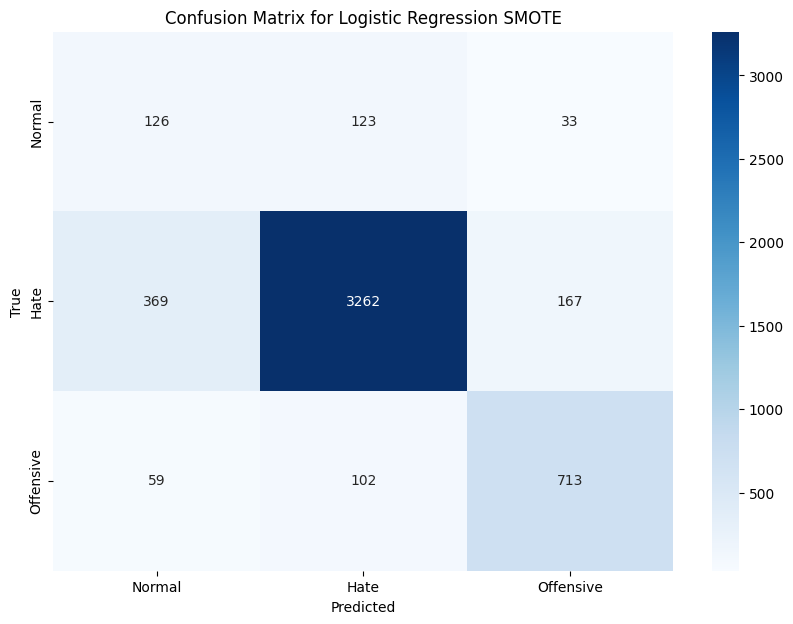

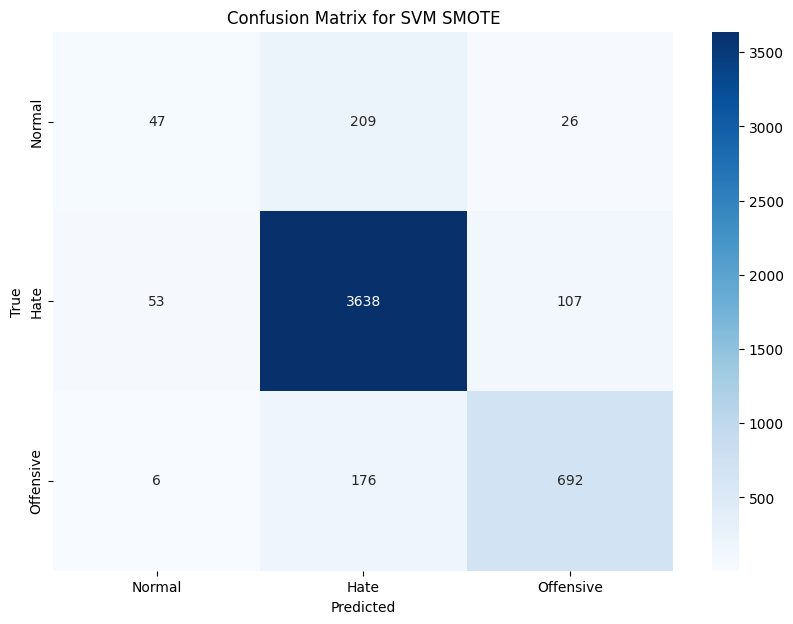

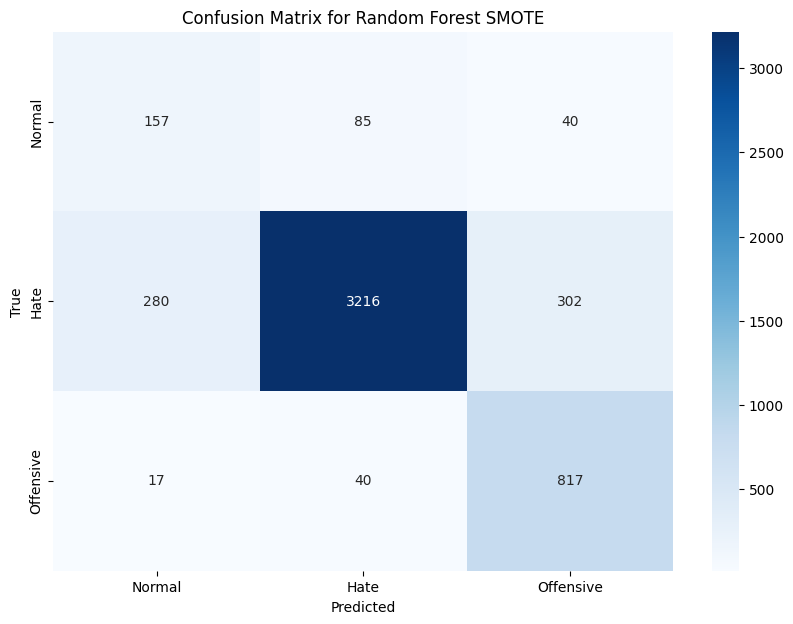

In [43]:
for name, model in models.items():
    y_pred = model.predict(X_test_tfidf)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Hate', 'Offensive'], yticklabels=['Normal', 'Hate', 'Offensive'])
    plt.title(f"Confusion Matrix for {name}")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


## SAVING THE BEST MODEL

In [44]:
model_filename = f"best_{best_model_name.replace(' ', '_').lower()}.pkl"
with open(model_filename, 'wb') as file:
    pickle.dump(best_model, file)

print(f"Best model saved as {model_filename}.")


Best model saved as best_svm_smote.pkl.
